In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
# pd.set_option("max_columns", None)
# pd.set_option('max_colwidth', None)
from collections import defaultdict

nested_dict = lambda: defaultdict(nested_dict)

from pathlib import Path
home = str(Path.home())
base_path = os.path.join(home, 'workspace/multiLID/data/extract/run_1/')
base_path

'/home/lorenzp/workspace/multiLID/data/extract/run_1/'

# from .pt

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

In [3]:
def split_data(characteristics, characteristics_adv, noise, test_size=0.2, random_state=21):
    
    shape_adv = np.shape(characteristics_adv)[0]
    shape_char = np.shape(characteristics)[0]
    
    adv_X_train_val, adv_X_test, adv_y_train_val, adv_y_actual = train_test_split(characteristics_adv, np.ones(shape_adv),   test_size=test_size, random_state=random_state)
    b_X_train_val, b_X_test, b_y_train_val, b_y_actual         = train_test_split(characteristics,     np.zeros(shape_char), test_size=test_size, random_state=random_state)
    adv_X_train, adv_X_val, adv_y_train, adv_y_val             = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
    b_X_train, b_X_val, b_y_train, b_y_val                     = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)

    adv_X_train, adv_X_val, adv_y_train, adv_y_val           = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
    b_X_train, b_X_val, b_y_train, b_y_val                   = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)


    X_train = np.concatenate(( b_X_train, adv_X_train) )
    y_train = np.concatenate(( b_y_train, adv_y_train) )

    X_test = np.concatenate( (b_X_test, adv_X_test, b_X_val, adv_X_val) )
    y_actual = np.concatenate( (b_y_actual, adv_y_actual, b_y_val, adv_y_val) )


    return X_train, y_train, X_test, y_actual

In [11]:
def predictions(clf, X_test, scaler=None):
    if not scaler == None:
        X_test   = scaler.transform(X_test)
    y_hat    = clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    return y_hat, y_hat_pr

In [17]:
def RF(X_train, y_train, X_test, y_test):
    kwargs = {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 60, 'bootstrap': False}  

    clf = RandomForestClassifier(n_jobs=-1, **kwargs)
    clf.fit(X_train, y_train)
    y_hat, y_hat_pr = predictions(clf, X_test)
    
    return  y_hat, y_hat_pr

In [18]:
def LR(X_train, y_train, X_test, y_test):
    scaler  = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    kwargs = {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 0.01}
    clf = LogisticRegression(n_jobs=-1, **kwargs)
    clf.fit(X_train, y_train)
    y_hat =    clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    
    return y_hat, y_hat_pr

In [26]:
NR_SAMPLES=2000
epsilonl2=['0.1', '0.2', '0.3', '0.4', '0.5']
epsilonl2_labels  = ['0.1', '0.2', '0.3', '0.4', '0.5' ]
epsilonlinf=[ '05255', '1255', '2255', '4255' , '8255']
epsilonlinf_labels=[ '0.5/255', '1/255', '2/255', '4/255', '8/255']
colors=['blue', 'orange', 'green', 'red', 'purple']
length=0
eps=['01', '02', '03', '04', '05']

attacks = ['apgd-ce']

In [20]:
def create_auc(eps, attacks, dataset='cifar10', method='LID', lid_ks=['3', '5', '10', '30', '50']):
    dict_res_rf = {}
    dict_res_lr = {}
    
    if '0.1' in eps:
        norm = 'l2'
    else:
        norm = 'linf'
        
    if dataset == 'cifar10':
        ds = 'cifar10/wrn28-10'
    else:
        ds = 'imagenet/wrn50-2'
    

    table_rf = np.zeros((len(eps), len(lid_ks)))
    table_lr = np.zeros((len(eps), len(lid_ks)))

    for att in attacks:
        auc_list_rf = []
        auc_list_lr = []
        for run_nr in [1,2,3]:
            print("attack", att)
            random_state = np.random.randint(0, 100)
            for i_eps, ep in enumerate(eps):
                for j_eps, lid_k in enumerate(lid_ks):
                    curr_eps = ""
                    if att in ['apgd-ce', 'fgsm', 'bim', 'pgd', 'aa']:
                        curr_eps = "_" + ep
                    
                    clean     = torch.load(os.path.join(base_path.replace('run_1', 'run_{}'.format(run_nr)), ds + '/{}/{}/k{}/{}_normalos_apgd-ce_{}{}.pt'.format(method.lower(), att, lid_k, method.lower(), norm, curr_eps)) ).numpy()[:NR_SAMPLES]
                    chars_adv = torch.load(os.path.join(base_path.replace('run_1', 'run_{}'.format(run_nr)), ds + '/{}/{}/k{}/{}_adverlos_apgd-ce_{}{}.pt'.format(method.lower(), att, lid_k, method.lower(), norm, curr_eps)) ).numpy()[:NR_SAMPLES]

                    characteristics_re     = clean.reshape((clean.shape[0], -1))
                    characteristics_adv_re = chars_adv.reshape((chars_adv.shape[0], -1))

                    X_train, y_train, X_test, y_test = split_data(characteristics_re, characteristics_adv_re, noise=False, test_size=0.2, random_state=random_state)

                    y_hat, y_hat_pr = RF(X_train, y_train, X_test, y_test)
                    auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
                    table_rf[i_eps,j_eps] = auc

                    y_hat, y_hat_pr = LR(X_train, y_train, X_test, y_test)
                    auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
                    table_lr[i_eps,j_eps] = auc

            auc_list_rf.append(table_rf.copy())
            auc_list_lr.append(table_lr.copy())

        dict_res_rf[att] = auc_list_rf
        dict_res_lr[att] = auc_list_lr
    
    stacked_rf = np.stack(dict_res_rf[att])
    mean_rf = np.mean(stacked_rf, axis=0)
    var_rf = np.var(stacked_rf, axis=0)
    
    stacked_lr = np.stack(dict_res_lr[att])
    mean_lr = np.mean(stacked_lr, axis=0)
    var_lr = np.var(stacked_lr, axis=0)
    
    return stacked_rf, mean_rf, var_rf, stacked_lr, mean_lr, var_lr

In [21]:
lid_l2_stacked_rf, lid_l2_mean_rf, lid_l2_var_rf, lid_l2_stacked_lr, lid_l2_mean_lr, lid_l2_var_lr = create_auc(eps=epsilonl2, dataset='cifar10', attacks=['apgd-ce'], method='LID', lid_ks=['3', '5', '10', '30', '50'])

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

In [22]:
mlid_l2_stacked_rf, mlid_l2_mean_rf, mlid_l2_var_rf, mlid_l2_stacked_lr, mlid_l2_mean_lr, mlid_l2_var_lr = create_auc(eps=epsilonl2, dataset='cifar10', attacks=['apgd-ce'], method='multiLID', lid_ks=['3', '5', '10', '30', '50'])

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

In [23]:
def plot_fig(stacked_rf, mean_rf, var_rf, stacked_lr, mean_lr, var_lr, epsilons, labels, lid_ks):
    fig, ax = plt.subplots()
    plt.xlabel("$k$")
    plt.ylabel("AUC")
    plt.xticks(lid_ks)
    ks = [3,5,10,30,50]
    ks_arr = np.array(ks)
    
    if '0.1' in epsilons:
         plt.title(f"APGD-CE $L^2$ - LID - AUC values per $k$")
    else:
        plt.title(f"APGD-CE $L^\infty$ - LID - AUC values per $k$")
    
   

    for iter2, ep in enumerate(epsilons):
        plt.fill_between([3,5,10,30,50], mean_rf[:,iter2]-var_rf[:,iter2], mean_rf[:,iter2]+var_rf[:,iter2], alpha=0.2, color=colors[iter2])
        plt.plot(ks_arr, mean_rf[:,iter2], marker='o', markersize=5, alpha=0.5, color=colors[iter2], label=labels[iter2])

    # legend = ax.legend( bbox_to_anchor=(1.0, 0.75), title='RF ($\epsilon$)', loc=6, framealpha=0.3)
    legend = ax.legend( bbox_to_anchor=(1.0, 0.75), title='LID', loc=6, framealpha=0.3)
    plt.gca().add_artist(legend)
    
    saved = []
    for iter2, ep in enumerate(epsilons):
        plt.fill_between(ks_arr, mean_lr[:,iter2]-var_lr[:,iter2], mean_lr[:,iter2]+var_lr[:,iter2], alpha=0.2, color=colors[iter2] )
        aa = plt.plot(ks_arr, mean_lr[:,iter2], marker='v', markersize=5, alpha=0.5, color=colors[iter2], label=labels[iter2])
        saved.append(aa)
        
    #legend2 = plt.legend(saved[0] + saved[1]+ saved[2]+ saved[3]+ saved[4], epsilonl2_labels, bbox_to_anchor=(1.0, 0.3),  title='LR ($\epsilon$)',  loc=6, framealpha=0.3)
    legend2 = plt.legend(saved[0]+saved[1]+saved[2]+saved[3]+saved[4], labels, bbox_to_anchor=(1.0, 0.3),  title='multiLID',  loc=6, framealpha=0.3)
    # plt.gca().add_artist(legend2)

    plt.grid(which='major', alpha=0.2)

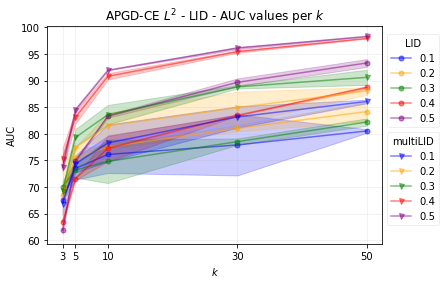

In [24]:
plot_fig(
    lid_l2_stacked_lr, 
    lid_l2_mean_lr, 
    lid_l2_var_lr, 
    mlid_l2_stacked_rf, 
    mlid_l2_mean_rf, 
    mlid_l2_var_rf, 
    epsilonl2, epsilonl2_labels, [3, 5, 10, 30, 50])
plt.savefig("plots/lines_over_k/fill_apgd-ce_l2.png", bbox_inches='tight', dpi=300)

In [28]:
lid_linf_stacked_rf, lid_linf_mean_rf, lid_linf_var_rf, lid_linf_stacked_lr, lid_linf_mean_lr, lid_linf_var_lr = create_auc(eps=epsilonlinf, attacks=['apgd-ce'], dataset='cifar10', method='LID', lid_ks=['3', '5', '10', '30', '50'])

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

In [30]:
mlid_linf_stacked_rf, mlid_linf_mean_rf, mlid_linf_var_rf, mlid_linf_stacked_lr, mlid_linf_mean_lr, mlid_linf_var_lr = create_auc(eps=epsilonlinf, attacks=['apgd-ce'], dataset='cifar10', method='multiLID', lid_ks=['3', '5', '10', '30', '50'])

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

attack apgd-ce


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/lorenzp/.c

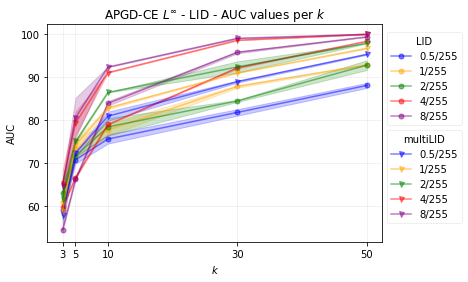

In [31]:
plot_fig(
    lid_linf_stacked_lr, 
    lid_linf_mean_lr, 
    lid_linf_var_lr, 
    mlid_linf_stacked_rf, 
    mlid_linf_mean_rf, 
    mlid_linf_var_rf, 
    epsilonlinf, epsilonlinf_labels, [3, 5, 10, 30, 50]
)
plt.savefig("plots/lines_over_k/fill_apgd-ce_linf.png", bbox_inches='tight', dpi=300)